In [1]:

# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
# from tensorflow import keras

from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
# import tensorflow as tf
#tf.config.gpu.set_per_process_memory_fraction(0.75)
#tf.config.gpu.set_per_process_memory_growth(True)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 300
l = 8
num_filter = 38
compression = 0.94


In [5]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 2s 0us/step


In [6]:
X_train.shape

(50000, 32, 32, 3)

In [7]:
X_test.shape

(10000, 32, 32, 3)

In [0]:
# Dense Block
def denseblock(input, num_filter = 12):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)

    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    conv = layers.Conv2D(num_classes, (3,3), padding='same')(AvgPooling)
    AvgPooling1 = layers.AveragePooling2D()(conv)
    flat = layers.Flatten()(AvgPooling1)
    output = layers.Activation('softmax')(flat)

    return output

In [9]:
num_filter = 20

l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter)
First_Transition = transition(First_Block, num_filter)

Second_Block = denseblock(First_Transition, num_filter)
Second_Transition = transition(Second_Block, num_filter)

Third_Block = denseblock(Second_Transition, num_filter)
Third_Transition = transition(Third_Block, num_filter)

Last_Block = denseblock(Third_Transition,  num_filter)
output = output_layer(Last_Block)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


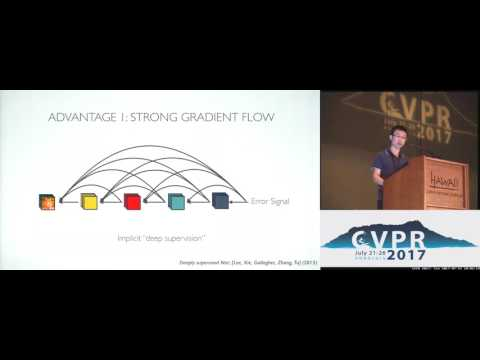

In [10]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [11]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 20)   540         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 20)   80          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 20)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:

from time import time
from datetime import datetime
from tensorflow.python.keras.callbacks import TensorBoard
#https://keras.rstudio.com/reference/callback_model_checkpoint.html
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath = "weights.{epoch:02d}-{val_loss:.2f}.hdf5"
history = tf.keras.callbacks.History()

# https://docs.w3cub.com/tensorflow~python/tf/keras/callbacks/reducelronplateau/
tensorboard = TensorBoard(log_dir="model_logs/{}".format(time()))

filepath = "weights.{epoch:02d}-{val_loss:.2f}.hdf5"
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
checkpoint_save = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint_save,learning_rate_reduction,history,tensorboard]

In [0]:
#https://keras.io/preprocessing/image/
#Data agumentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    #featurewise_center=True, This was overfitting so commented this out
    #featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.10)
datagen.fit(X_train)

In [0]:
# determine Loss function and Optimizer
# Tried with different optimizer Adam was giving best results
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [22]:

history = model.fit_generator(datagen.flow(X_train, y_train,
                        batch_size=batch_size),callbacks= callbacks_list,
                        epochs=100,verbose=0,
                        validation_data=(X_test, y_test))


Epoch 00001: val_acc did not improve from 0.89450

Epoch 00002: val_acc did not improve from 0.89450

Epoch 00003: val_acc improved from 0.89450 to 0.89700, saving model to weights.03-0.33.hdf5

Epoch 00004: val_acc did not improve from 0.89700

Epoch 00005: val_acc improved from 0.89700 to 0.89810, saving model to weights.05-0.33.hdf5

Epoch 00006: val_acc improved from 0.89810 to 0.90200, saving model to weights.06-0.31.hdf5

Epoch 00007: val_acc did not improve from 0.90200

Epoch 00008: val_acc did not improve from 0.90200

Epoch 00009: val_acc did not improve from 0.90200

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 00010: val_acc did not improve from 0.90200

Epoch 00011: val_acc did not improve from 0.90200

Epoch 00012: val_acc did not improve from 0.90200

Epoch 00013: val_acc did not improve from 0.90200

Epoch 00014: val_acc did not improve from 0.90200

Epoch 00015: val_acc did not improve from 0.90200

Epoch 00016: val_acc did not improve from 

In [0]:
# Save the trained weights in to .h5 format weights.294-0.31.hdf5
model.load_weights("/content/weights.93-0.32.hdf5")

In [45]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 5s 500us/sample - loss: 0.3196 - acc: 0.9139
Test loss: 0.3195843585461378
Test accuracy: 0.9139


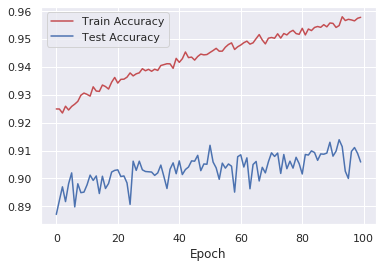

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.plot(history.history['acc'], 'r')
plt.plot(history.history['val_acc'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.xlabel('Epoch')
plt.show()